<div style="text-align: center;">
  <img src="image1.jpeg" width="800" style="max-width: 100%; height: auto;"/>
</div>


# Importation des packages

In [1]:
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
#import spacy
#import random
#from spacy.util import compounding
#from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Importation de la base de données

In [63]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
ss = pd.read_csv("sample_submission.csv")

In [64]:
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [66]:
train.dropna(inplace=True)

# EDA: Analyse de Données Exploratoire

In [67]:
train.describe()

textID                                  text selected_text  \
count        27480                                 27480         27480   
unique       27480                                 27480         22463   
top     cb774db0d1   I`d have responded, if I were going          good   
freq             1                                     1           199   

       sentiment  
count      27480  
unique         3  
top      neutral  
freq       11117

**Quelle est la proportion des sentiments sur l'effectif total**

In [68]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

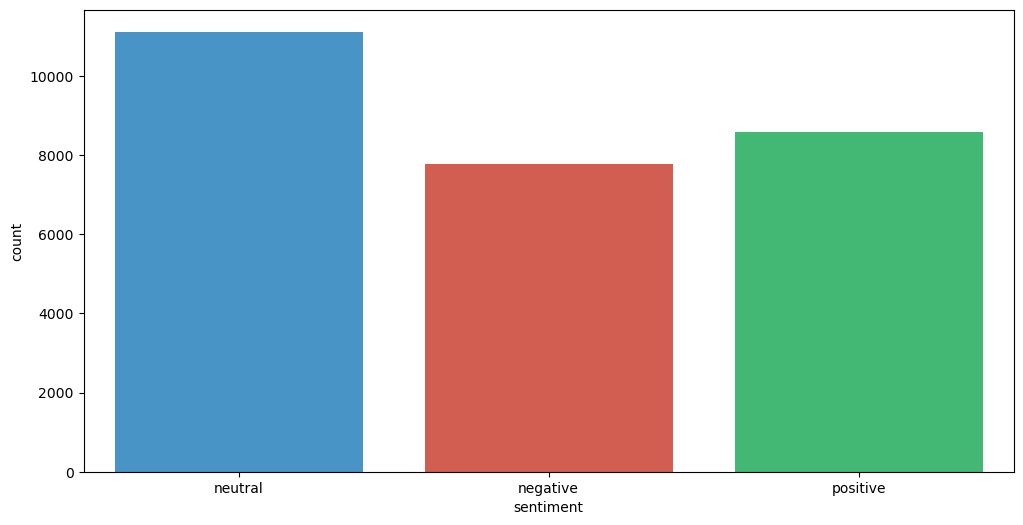

In [69]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment', data=train, palette=['#3498db', '#e74c3c', '#2ecc71'])  # Exemple avec couleurs personnalisées
plt.show()

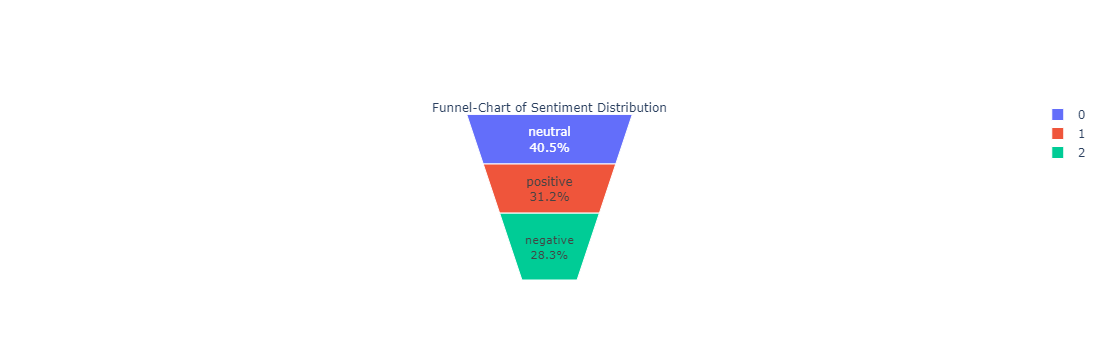

In [70]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

# Que savons-nous actuellement de nos données :
Avant de commencer, examinons certaines choses que nous savons déjà sur les données et qui nous aideront à obtenir de nouvelles informations :

Nous savons que selected_text est un sous-ensemble de text.
Nous savons que selected_text contient uniquement un segment de texte, c'est-à-dire qu'il ne saute pas entre deux phrases. Par exemple, si le texte est : "J'ai passé toute la matinée en réunion avec un fournisseur, et mon patron n'était pas content d'eux. Beaucoup de plaisir. J'avais d'autres plans pour ma matinée", alors le selected_text peut être : "mon patron n'était pas content d'eux. Beaucoup de plaisir" ou "Beaucoup de plaisir" mais ne peut pas être : "Matin, fournisseur et mon patron".

### Similarité de Jaccard

La **similarité de Jaccard** est une mesure de similarité entre deux ensembles. Elle est définie comme le rapport entre la taille de l'intersection des ensembles et la taille de leur union. En d'autres termes, elle quantifie à quel point deux ensembles sont similaires en fonction des éléments qu'ils partagent.

#### Formule de la Similarité de Jaccard

Pour deux ensembles \( A \) et \( B \), la similarité de Jaccard est calculée comme suit :
$
[
\text{Similarité de Jaccard} = \frac{|A \cap B|}{|A \cup B|}
]
$
où :
- $( |A \cap B| )$ est le nombre d'éléments communs aux deux ensembles.
- $( |A \cup B| $) est le nombre total d'éléments dans l'union des deux ensembles.

#### Exemple de Calcul

Supposons que vous ayez deux ensembles :
- \( A = \{1, 2, 3, 4\} \)
- \( B = \{3, 4, 5, 6\} \)

- **Intersection** $( A \cap B $) : \({3, 4\}) (2 éléments)
- **Union** $( A \cup B ) : (\{1, 2, 3, 4, 5, 6\})$ (6 éléments)

La similarité de Jaccard est donc :
$
[
\text{Similarité de Jaccard} = \frac{2}{6} = 0.33
]
$
Cela signifie que les ensembles \( A \) et \( B \) ont une similarité de 33 %.

#### Reconnaître la Similarité de Jaccard

La similarité de Jaccard est souvent utilisée pour :
- Comparer la similarité entre deux ensembles de mots dans des documents ou des tweets.
- Évaluer la similarité entre des ensembles de caractéristiques ou des ensembles d'éléments dans divers contextes d'analyse de données.

Dans le contexte des textes, cette mesure peut être utilisée pour comparer la similarité entre deux segments de texte en les représentant comme des ensembles de mots ou de caractères. Une haute similarité de Jaccard indique que les textes partagent une proportion élevée d'éléments communs, tandis qu'une faible similarité indique qu'ils sont assez différents.


In [71]:
def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [72]:
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [73]:
jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
train = train.merge(jaccard,how='outer')

In [74]:
train

textID                                               text  \
0      0fab80d6b2                    \tREALLY?? oh.. sorry yall  lol   
1      8106d4c6fa                          _beckett Thanks so much !   
2      3792c7b13e        You`ll be missed!!  Bring me back  a key...   
3      b58a92fe10                 get lit  I am  http://bit.ly/OASQR   
4      18180bb2ec       Good morning to you !  Its so pretty outs...   
...           ...                                                ...   
27475  1b54db957d  zoombezi bay was soooo fun!! buuuut my legs ar...   
27476  79a3f22848  {cont} that right their is why fake btches sho...   
27477  a38b466046  ~ Happy Star Wars Day.every one ~  ...may the ...   
27478  cc4a151d1d  ï¿½anisalovesu me too. I am so so upset,especi...   
27479  89e806e3e3  ï¿½ï¿½h. iï¿½m gonna go in the 'big' house now...   

                                           selected_text sentiment  \
0                                                  sorry  negative   
1                                         beckett Thanks  positive   
2                                         You`ll be miss  negative   
3                          get lit  I am  http://bit.ly/   neutral   
4                                              Its so pr  positive   
...                                                  ...       ...   
27475  zoombezi bay was soooo fun!! buuuut my legs ar...   neutral   
27476                                          excite me  positive   
27477                      Happy Star Wars Day.every one  positive   
27478  lovesu me too. I am so so upset,especially bec...   neutral   
27479  ï¿½ï¿½h. iï¿½m gonna go in the 'big' house now...   neutral   

       jaccard_score  
0           0.200000  
1           0.166667  
2           0.222222  
3           0.666667  
4           0.181818  
...              ...  
27475       1.000000  
27476       0.105263  
27477       0.416667  
27478       0.875000  
27479       1.000000  

[27480 rows x 5 columns]

In [75]:
train['Num_words_ST'] = train['selected_text'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text
train['Num_word_text'] = train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
train['difference_in_words'] = train['Num_word_text'] - train['Num_words_ST'] #Difference in Number of words text and Selected Text

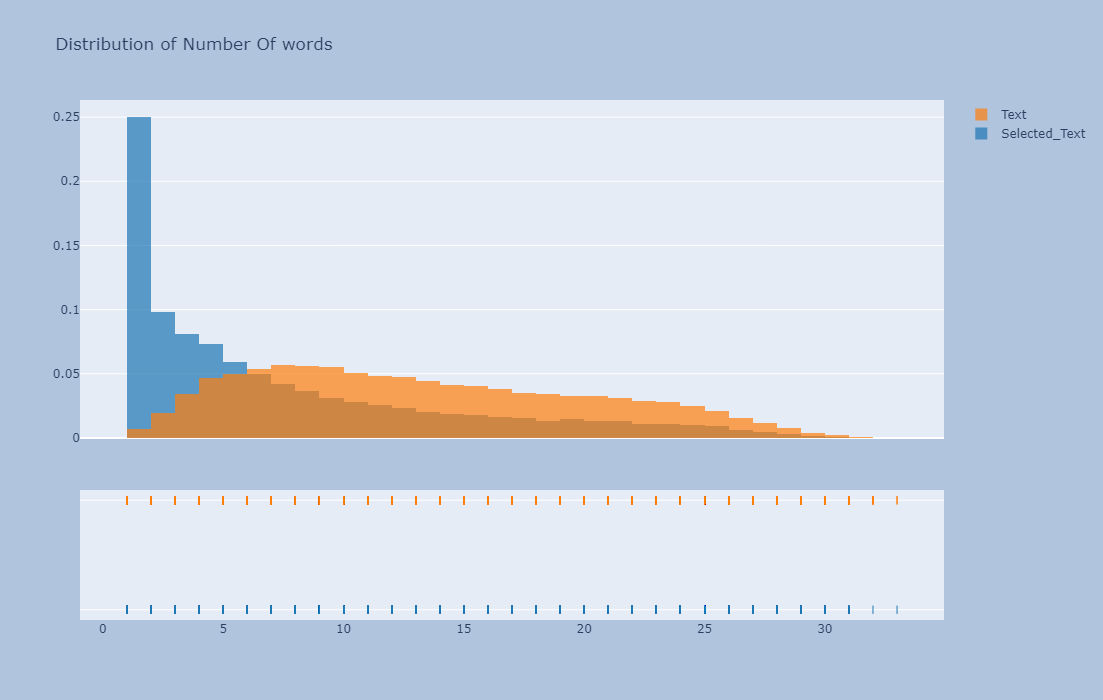

In [76]:
hist_data = [train['Num_words_ST'],train['Num_word_text']]
group_labels = ['Selected_Text', 'Text']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()


**Interprétation :**
Texte sélectionné (bleu) : La plupart des tweets sélectionnés ont très peu de mots, souvent entre 1 et 5. Le volume diminue fortement après cela, presque aucun extrait n'a plus de 15 mots.
Texte complet (orange) : Bien que les tweets complets aient aussi une majorité de courts textes, il y a un nombre significatif de tweets plus longs, jusqu'à environ 25 mots. Au-delà de 25 mots, il y a très peu de tweets.
En résumé, ce graphique montre que :

Les tweets sélectionnés sont généralement beaucoup plus courts que les tweets complets.
Il y a un grand nombre de tweets très courts (moins de 5 mots), et très peu de tweets dépassant 25 mots.








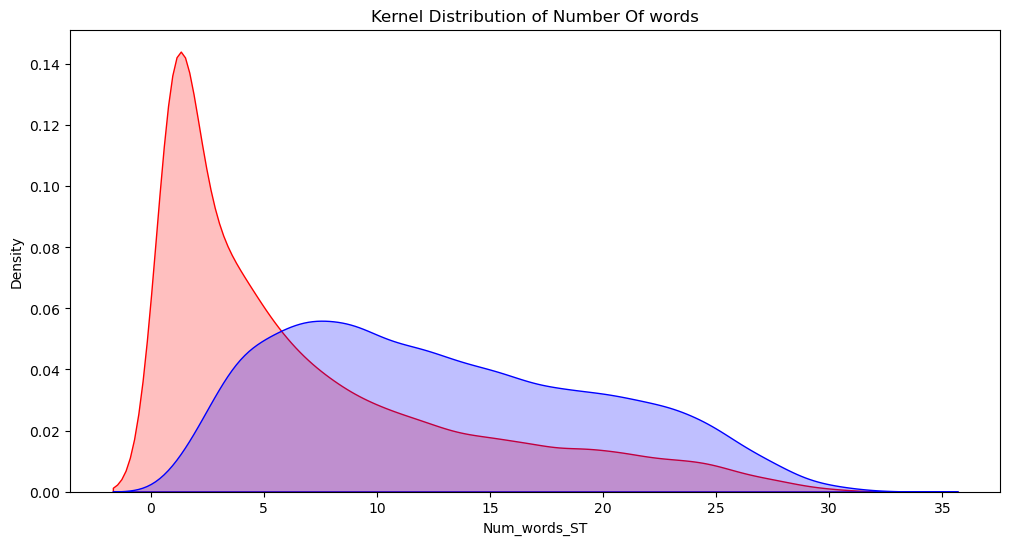

In [77]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train['Num_words_ST'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(train['Num_word_text'], shade=True, color="b")

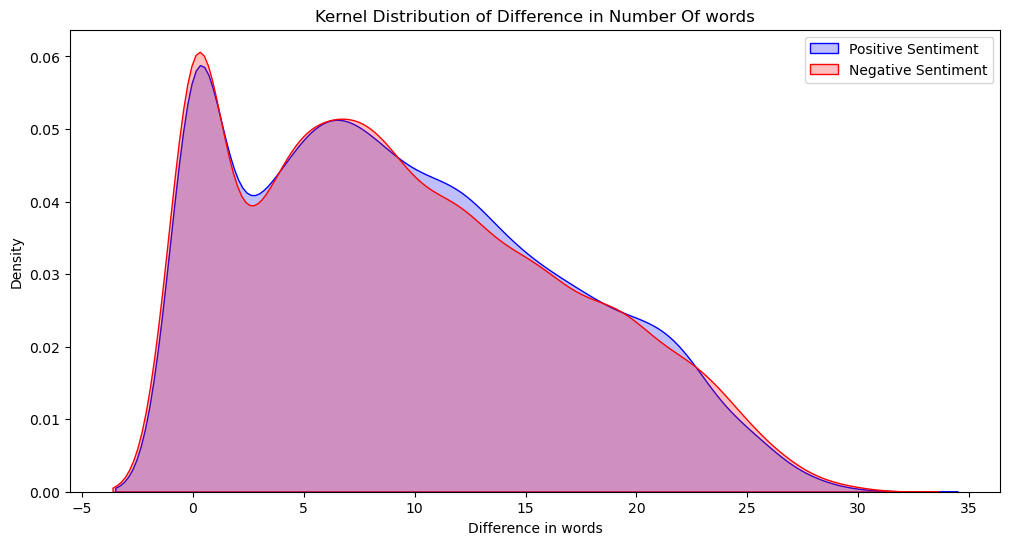

In [78]:
plt.figure(figsize=(12,6))
sns.kdeplot(train[train['sentiment']=='positive']['difference_in_words'], shade=True, color="b")
sns.kdeplot(train[train['sentiment']=='negative']['difference_in_words'], shade=True, color="r")
plt.title('Kernel Distribution of Difference in Number Of words')
plt.xlabel('Difference in words')
plt.ylabel('Density')
plt.legend(['Positive Sentiment', 'Negative Sentiment'])
plt.show()

<Axes: xlabel='difference_in_words'>

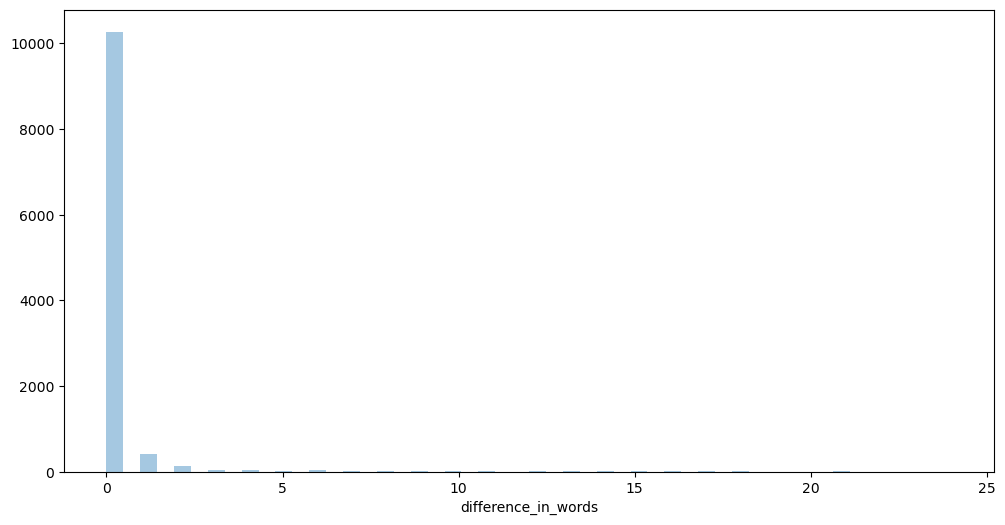

In [79]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['difference_in_words'],kde=False)

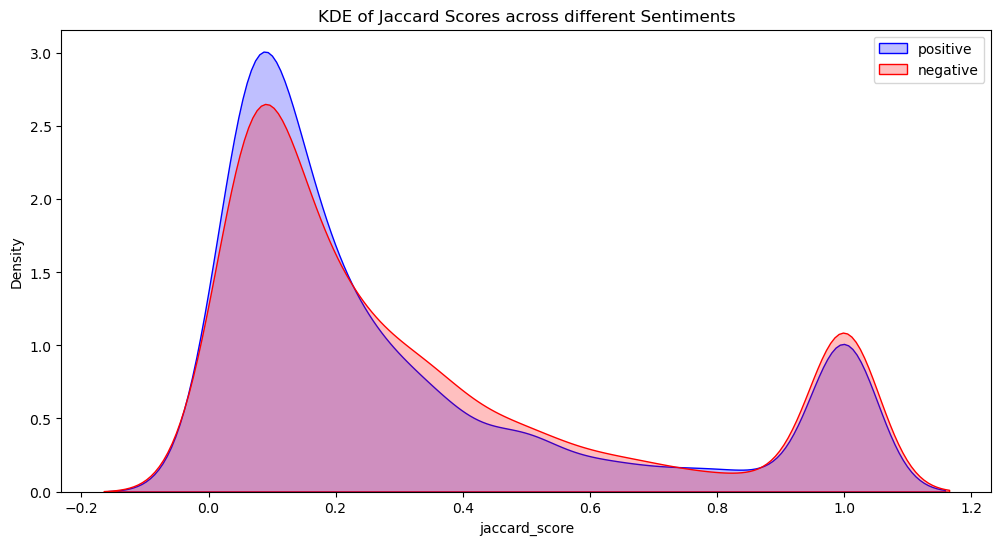

In [80]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['jaccard_score'], shade=True, color="b").set_title('KDE of Jaccard Scores across different Sentiments')
p2=sns.kdeplot(train[train['sentiment']=='negative']['jaccard_score'], shade=True, color="r")
plt.legend(labels=['positive','negative'])

<Axes: xlabel='jaccard_score'>

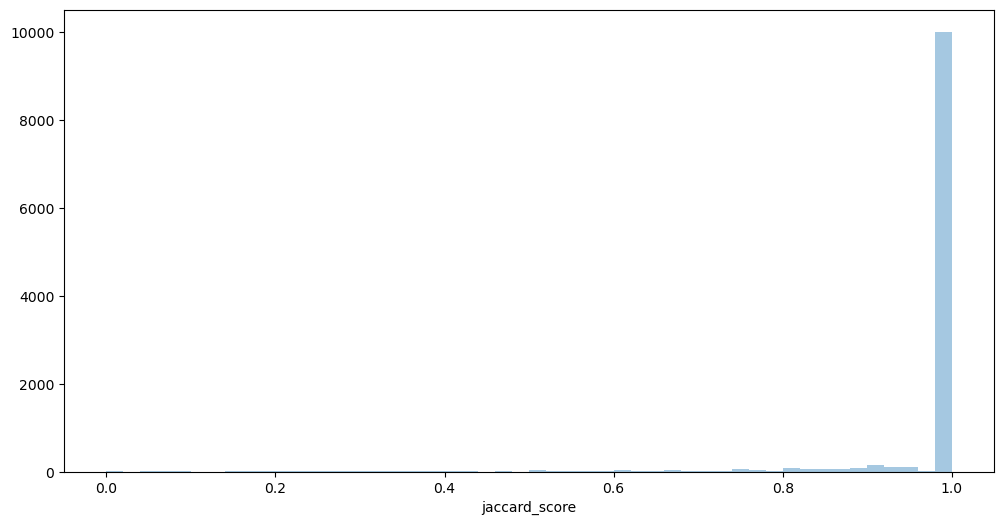

In [81]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['jaccard_score'],kde=False)

In [82]:
k = train[train['Num_word_text']<=2]

In [83]:
# Group by sentiment and calculate the mean Jaccard score
mean_jaccard_df = k.groupby('sentiment')['jaccard_score'].mean().reset_index()

# Apply the background gradient on the DataFrame
mean_jaccard_df.style.background_gradient(cmap='Purples')


In [84]:
k[k['sentiment']=='positive']

textID               text      selected_text sentiment  \
100    3ff9947935        **** right!        **** right!  positive   
151    d2f915b8c7      Good Morning!               Good  positive   
154    b4fa2d20e4           Good one           Good one  positive   
155    5714d8c2c3         Goodnight.          Goodnight  positive   
334    6d9bd35d32          Thank you              Thank  positive   
...           ...                ...                ...       ...   
26454  0ccac3f8b7  sweet situations.  sweet situations.  positive   
26484  6475ddf649            thanks              thanks  positive   
26499  274181e2e2             thanx               thanx  positive   
26933  28fc81d56a       wants cookie       wants cookie  positive   
27319  352e2cdec2        work   Yay!                Yay  positive   

       jaccard_score  Num_words_ST  Num_word_text  difference_in_words  
100              1.0             2              2                    0  
151              0.5             1              2                    1  
154              1.0             2              2                    0  
155              0.0             1              1                    0  
334              0.5             1              2                    1  
...              ...           ...            ...                  ...  
26454            1.0             2              2                    0  
26484            1.0             1              1                    0  
26499            1.0             1              1                    0  
26933            1.0             2              2                    0  
27319            0.0             1              2                    1  

[207 rows x 8 columns]

**Traitement de données stopwords**

In [85]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [86]:
train['text'] = train['text'].apply(lambda x:clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x:clean_text(x))

In [87]:
train.head() # ici on voit tout cela.

textID                                               text  \
0  0fab80d6b2                        \treally oh sorry yall  lol   
1  8106d4c6fa                            beckett thanks so much    
2  3792c7b13e         youll be missed  bring me back  a keychain   
3  b58a92fe10                                    get lit  i am     
4  18180bb2ec       good morning to you   its so pretty outsi...   

     selected_text sentiment  jaccard_score  Num_words_ST  Num_word_text  \
0            sorry  negative       0.200000             1              5   
1   beckett thanks  positive       0.166667             2              5   
2    youll be miss  negative       0.222222             3              8   
3  get lit  i am     neutral       0.666667             5              5   
4        its so pr  positive       0.181818             3             10   

   difference_in_words  
0                    4  
1                    3  
2                    5  
3                    0  
4                    7

In [88]:
train['temp_list'] = train['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

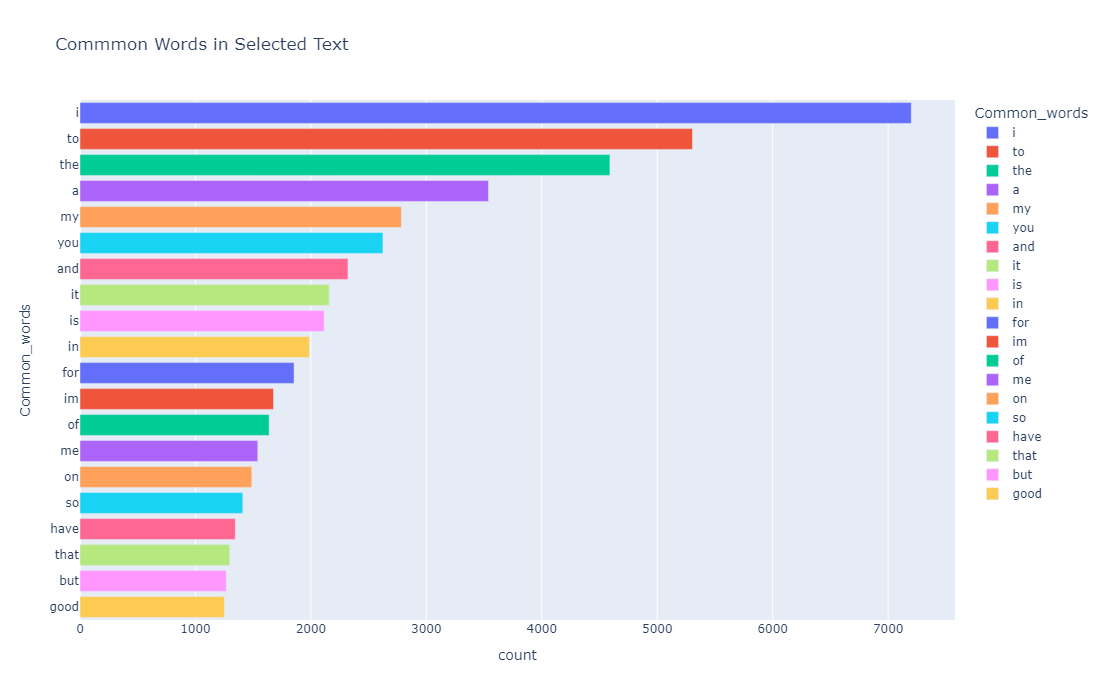

In [89]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [91]:
nltk.download('stopwords')
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
train['temp_list'] = train['temp_list'].apply(lambda x:remove_stopword(x))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NGASSAM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [92]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

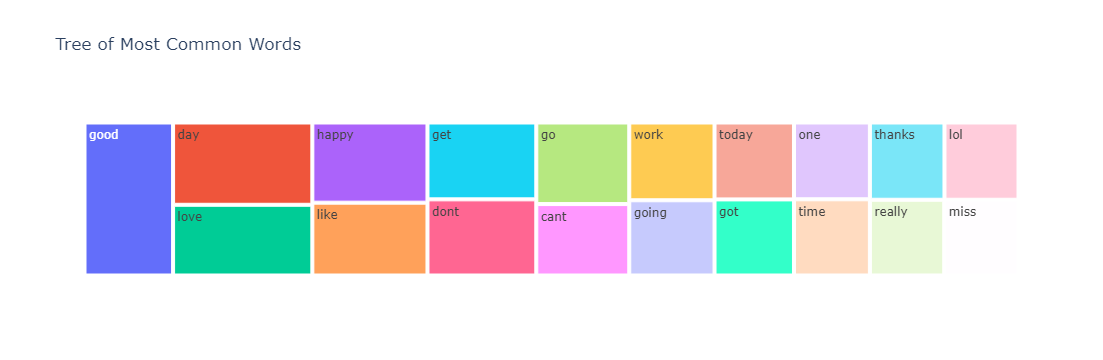

In [93]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

In [94]:
train['temp_list1'] = train['text'].apply(lambda x:str(x).split()) #List of words in every row for text
train['temp_list1'] = train['temp_list1'].apply(lambda x:remove_stopword(x)) #Removing Stopwords

In [95]:
top = Counter([item for sublist in train['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

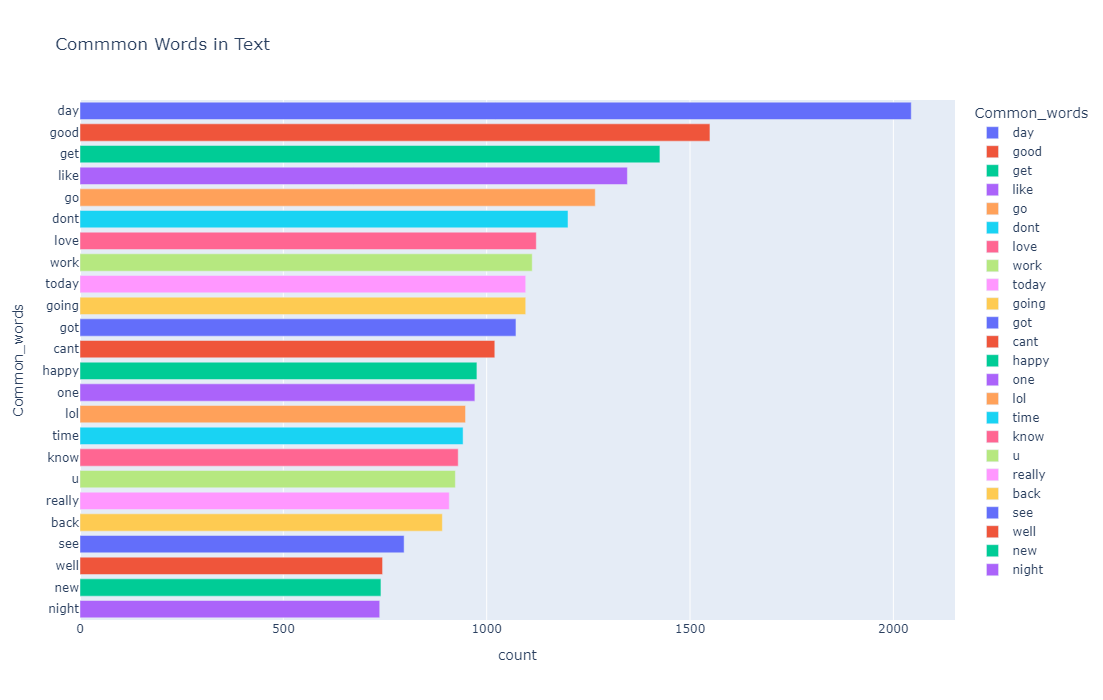

In [96]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [97]:
positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']

In [98]:
#MosT common positive words
top = Counter([item for sublist in positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

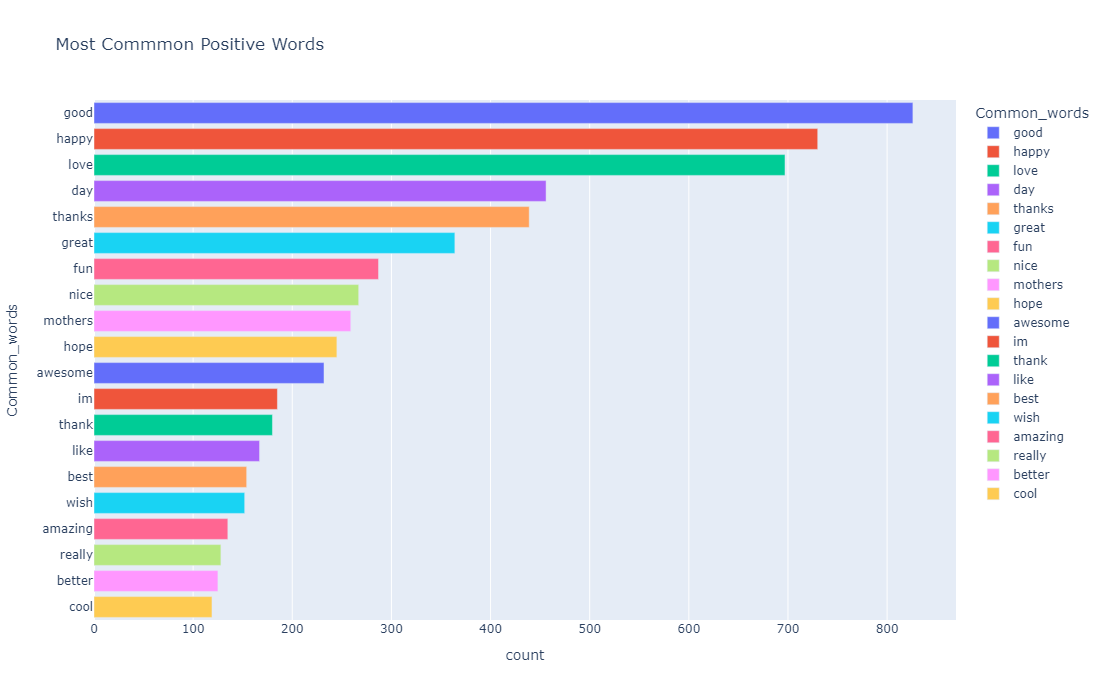

In [99]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [100]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

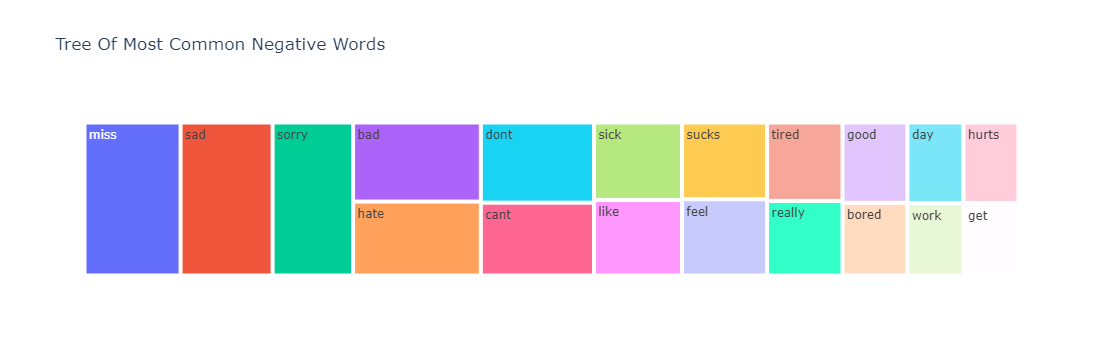

In [101]:
fig = px.treemap(temp_negative, path=['Common_words'], values='count',title='Tree Of Most Common Negative Words')
fig.show()

In [102]:
#MosT common Neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Reds')

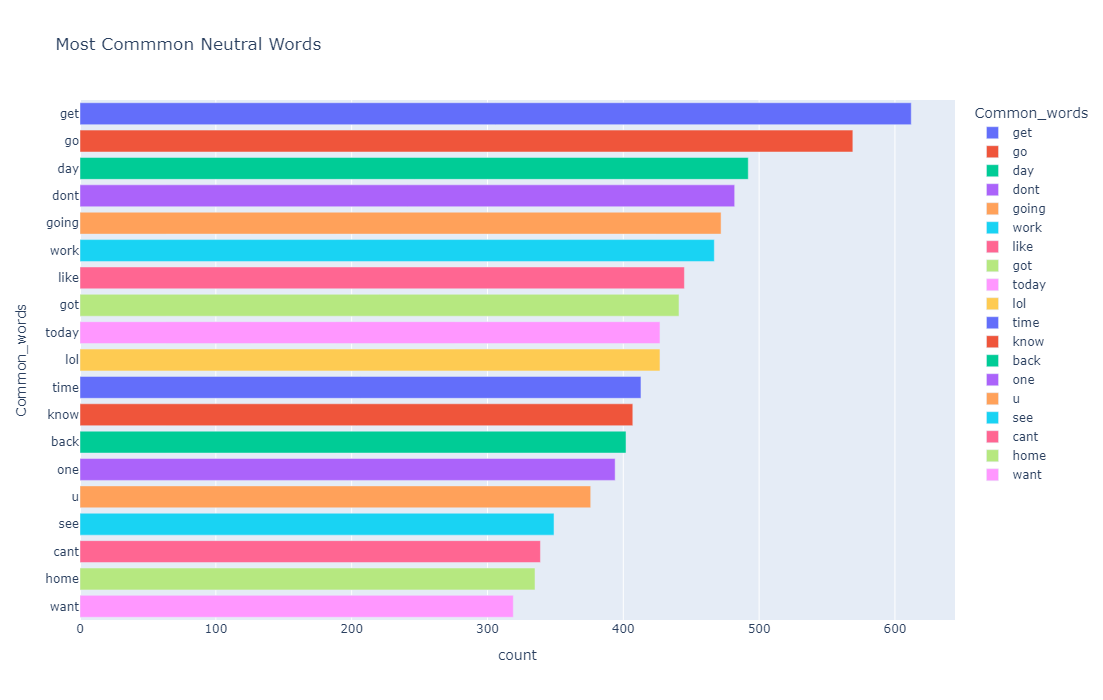

In [103]:
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

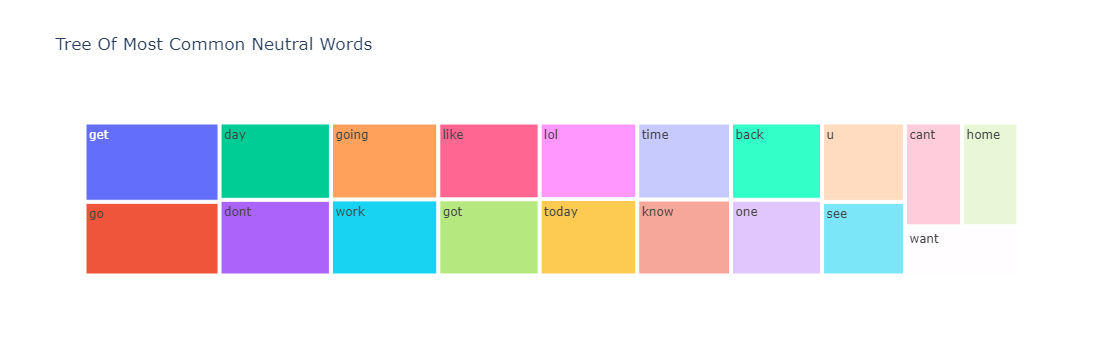

In [104]:
fig = px.treemap(temp_neutral, path=['Common_words'], values='count',title='Tree Of Most Common Neutral Words')
fig.show()

In [105]:
raw_text = [word for word_list in train['temp_list1'] for word in word_list]

In [110]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result;
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output:
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in train[train.sentiment != sentiment]['temp_list1']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))

    specificnonly = [x for x in raw_text if x not in allother]

    mycounter = Counter()

    for item in train[train.sentiment == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)

    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]

    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])

    return Unique_words

In [111]:
Unique_Positive= words_unique('positive', 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


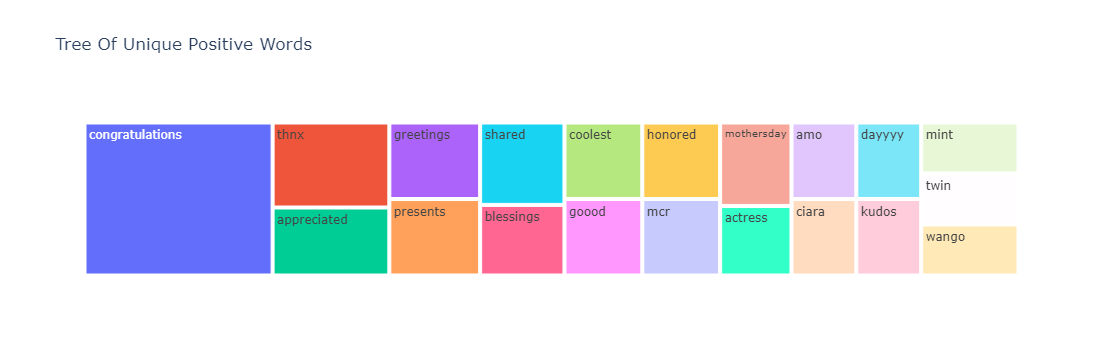

In [112]:
fig = px.treemap(Unique_Positive, path=['words'], values='count',title='Tree Of Unique Positive Words')
fig.show()

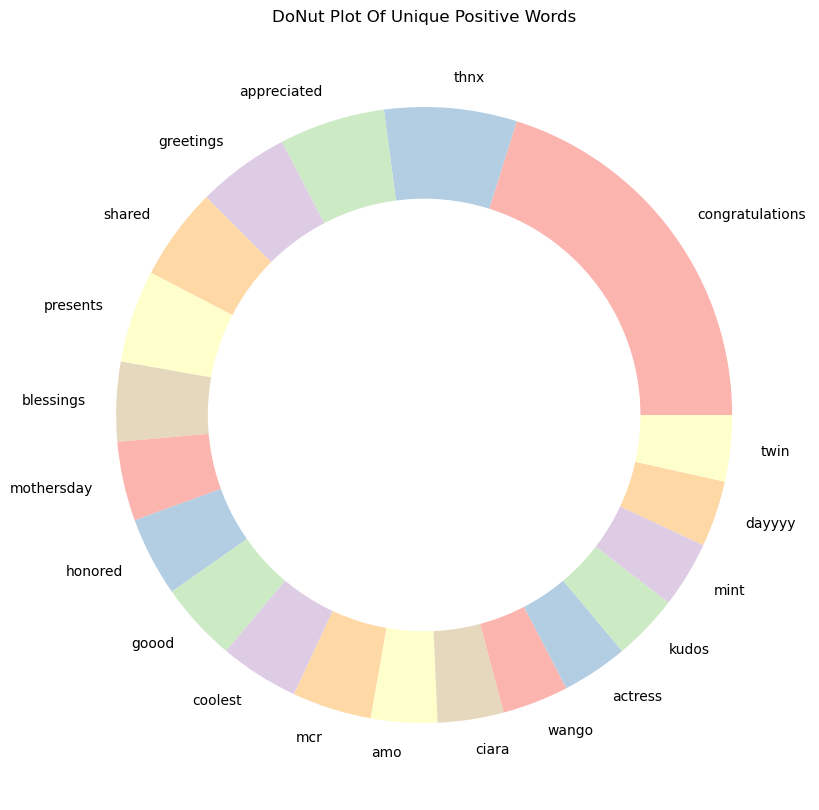

In [113]:
!pip install palettable
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Positive['count'], labels=Unique_Positive.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Positive Words')
plt.show()

In [114]:
Unique_Negative= words_unique('negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


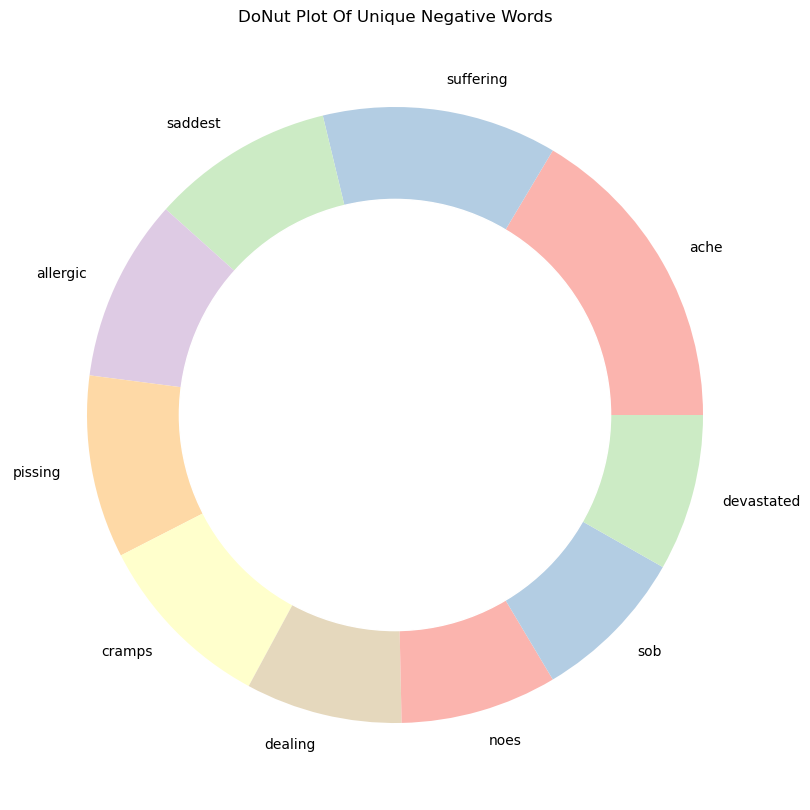

In [115]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.rcParams['text.color'] = 'black'
plt.pie(Unique_Negative['count'], labels=Unique_Negative.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Negative Words')
plt.show()

In [116]:
Unique_Neutral= words_unique('neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


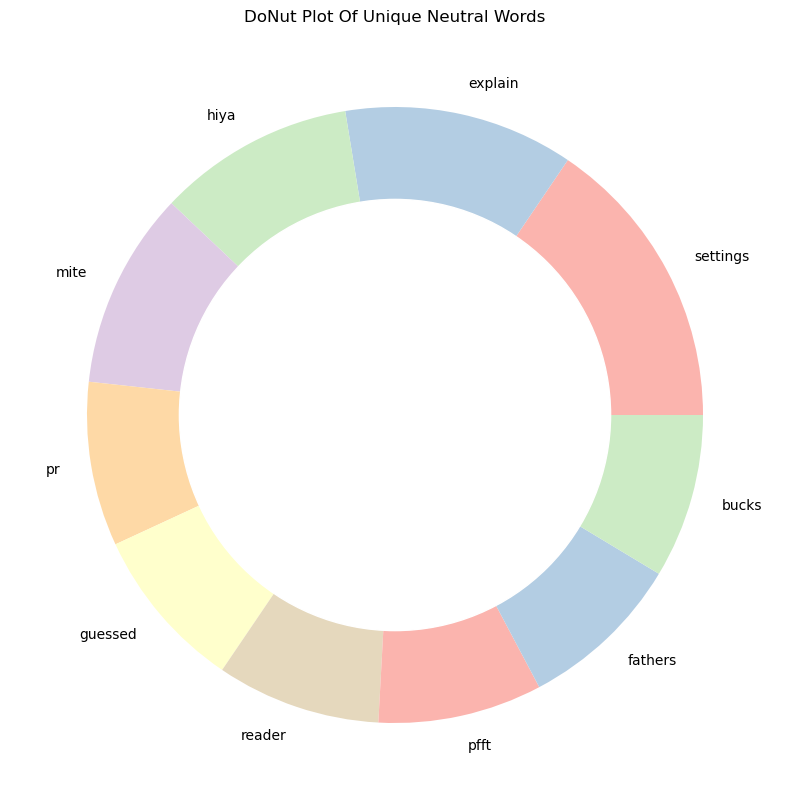

In [117]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Neutral['count'], labels=Unique_Neutral.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Neutral Words')
plt.show()

In [118]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    width=400,
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

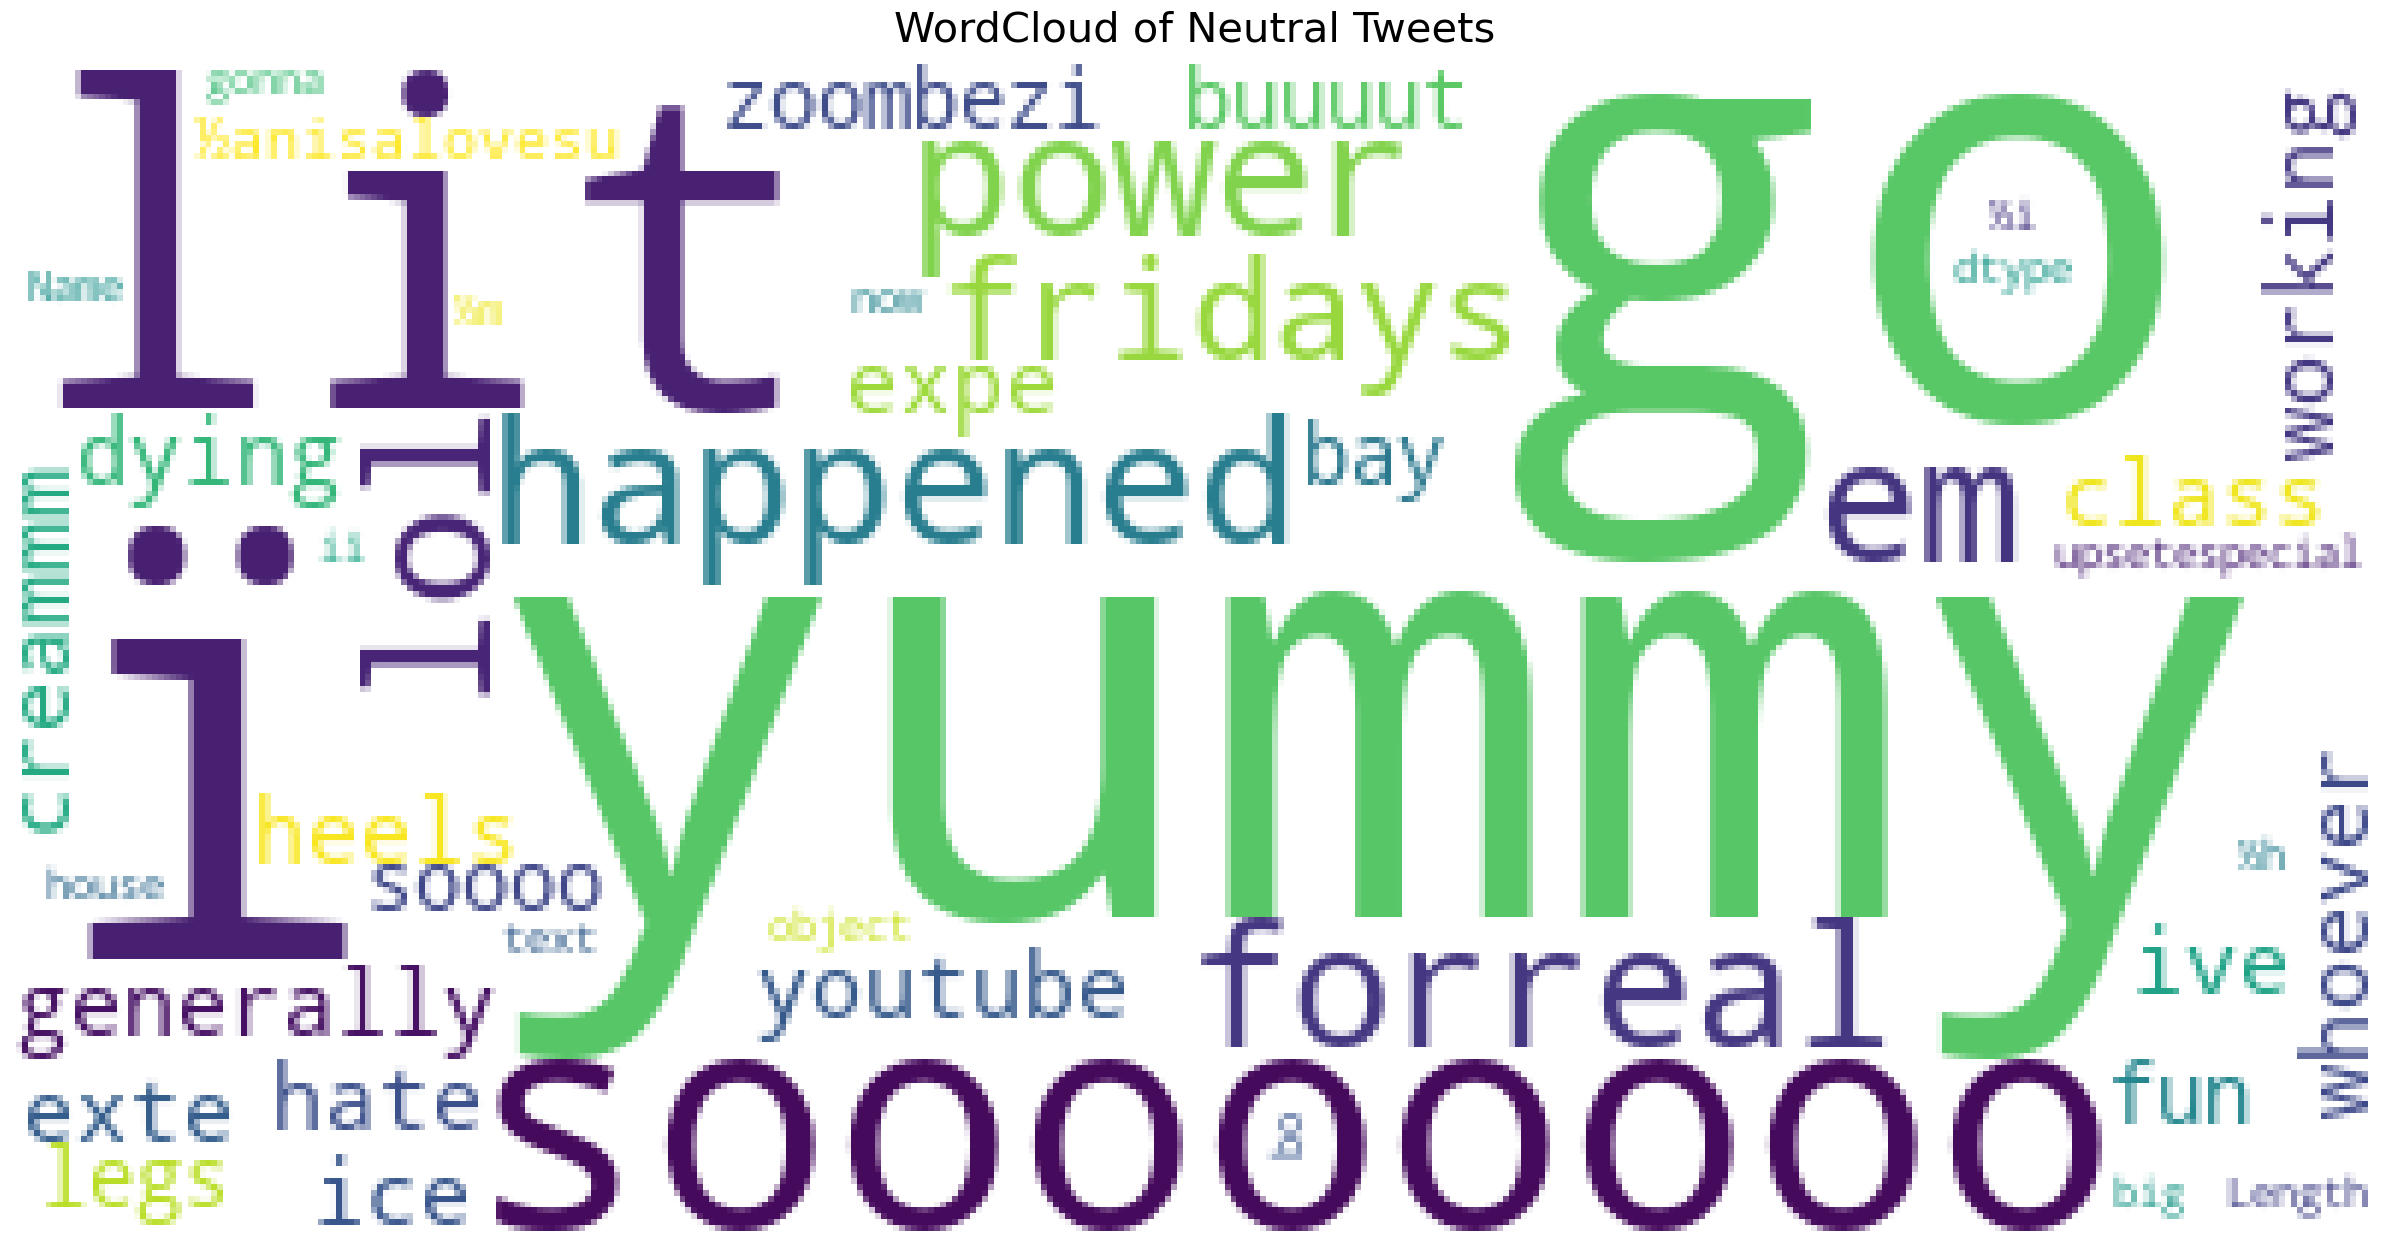

In [119]:
#pos_mask = np.array(Image.open(d+ 'twitter_mask.png'))
plot_wordcloud(Neutral_sent.text,color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")

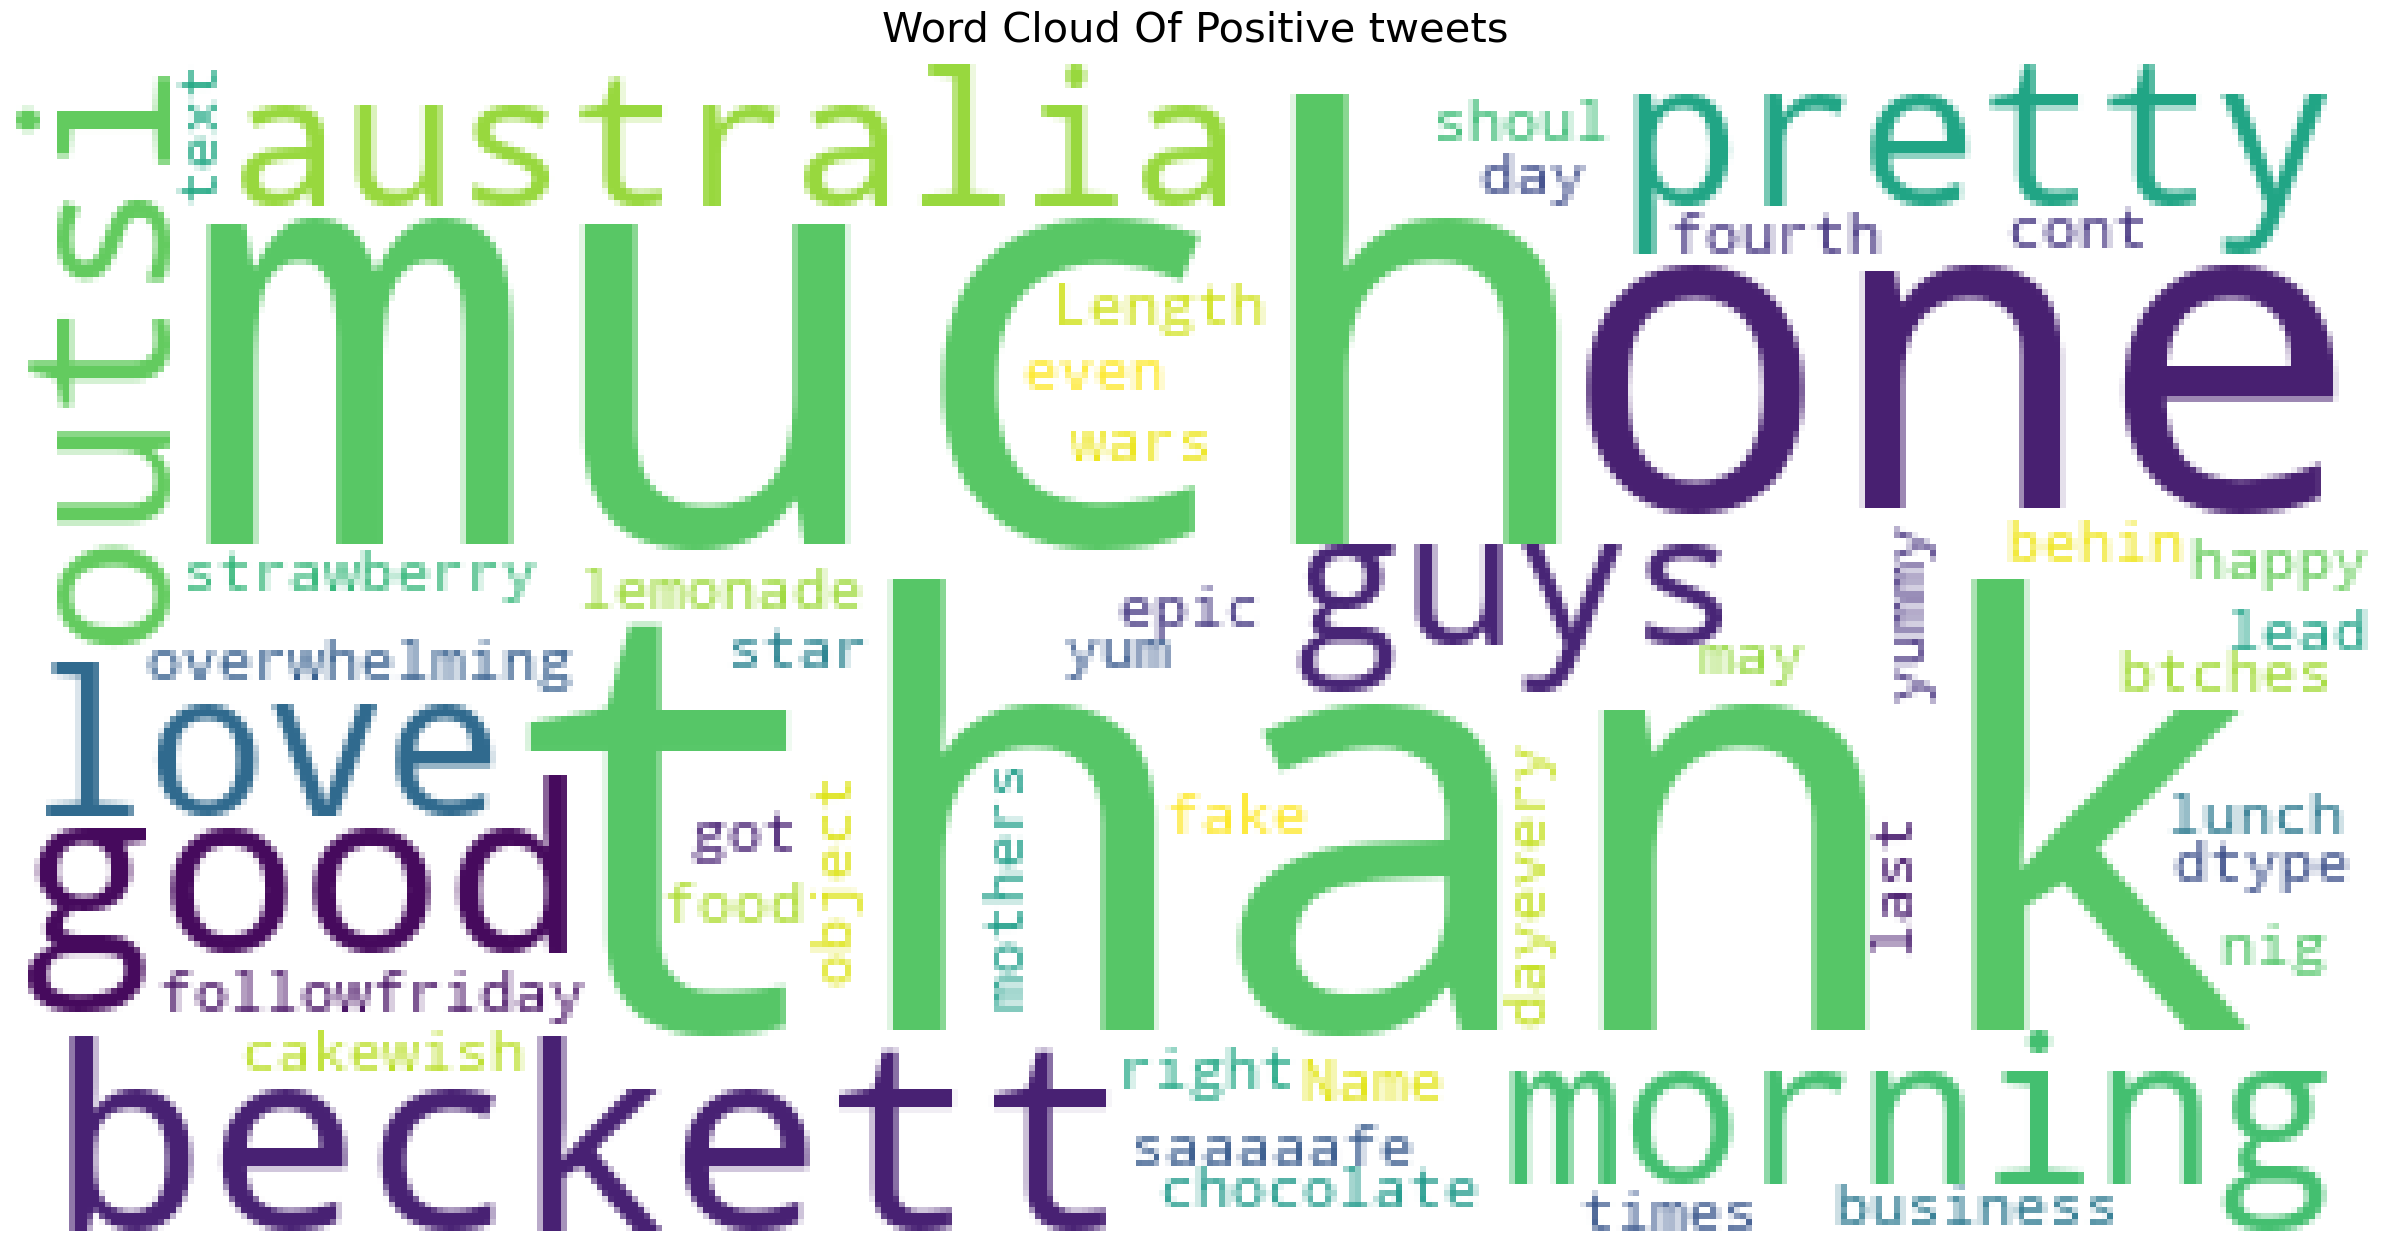

In [120]:
plot_wordcloud(positive_sent.text,title="Word Cloud Of Positive tweets",title_size=30)

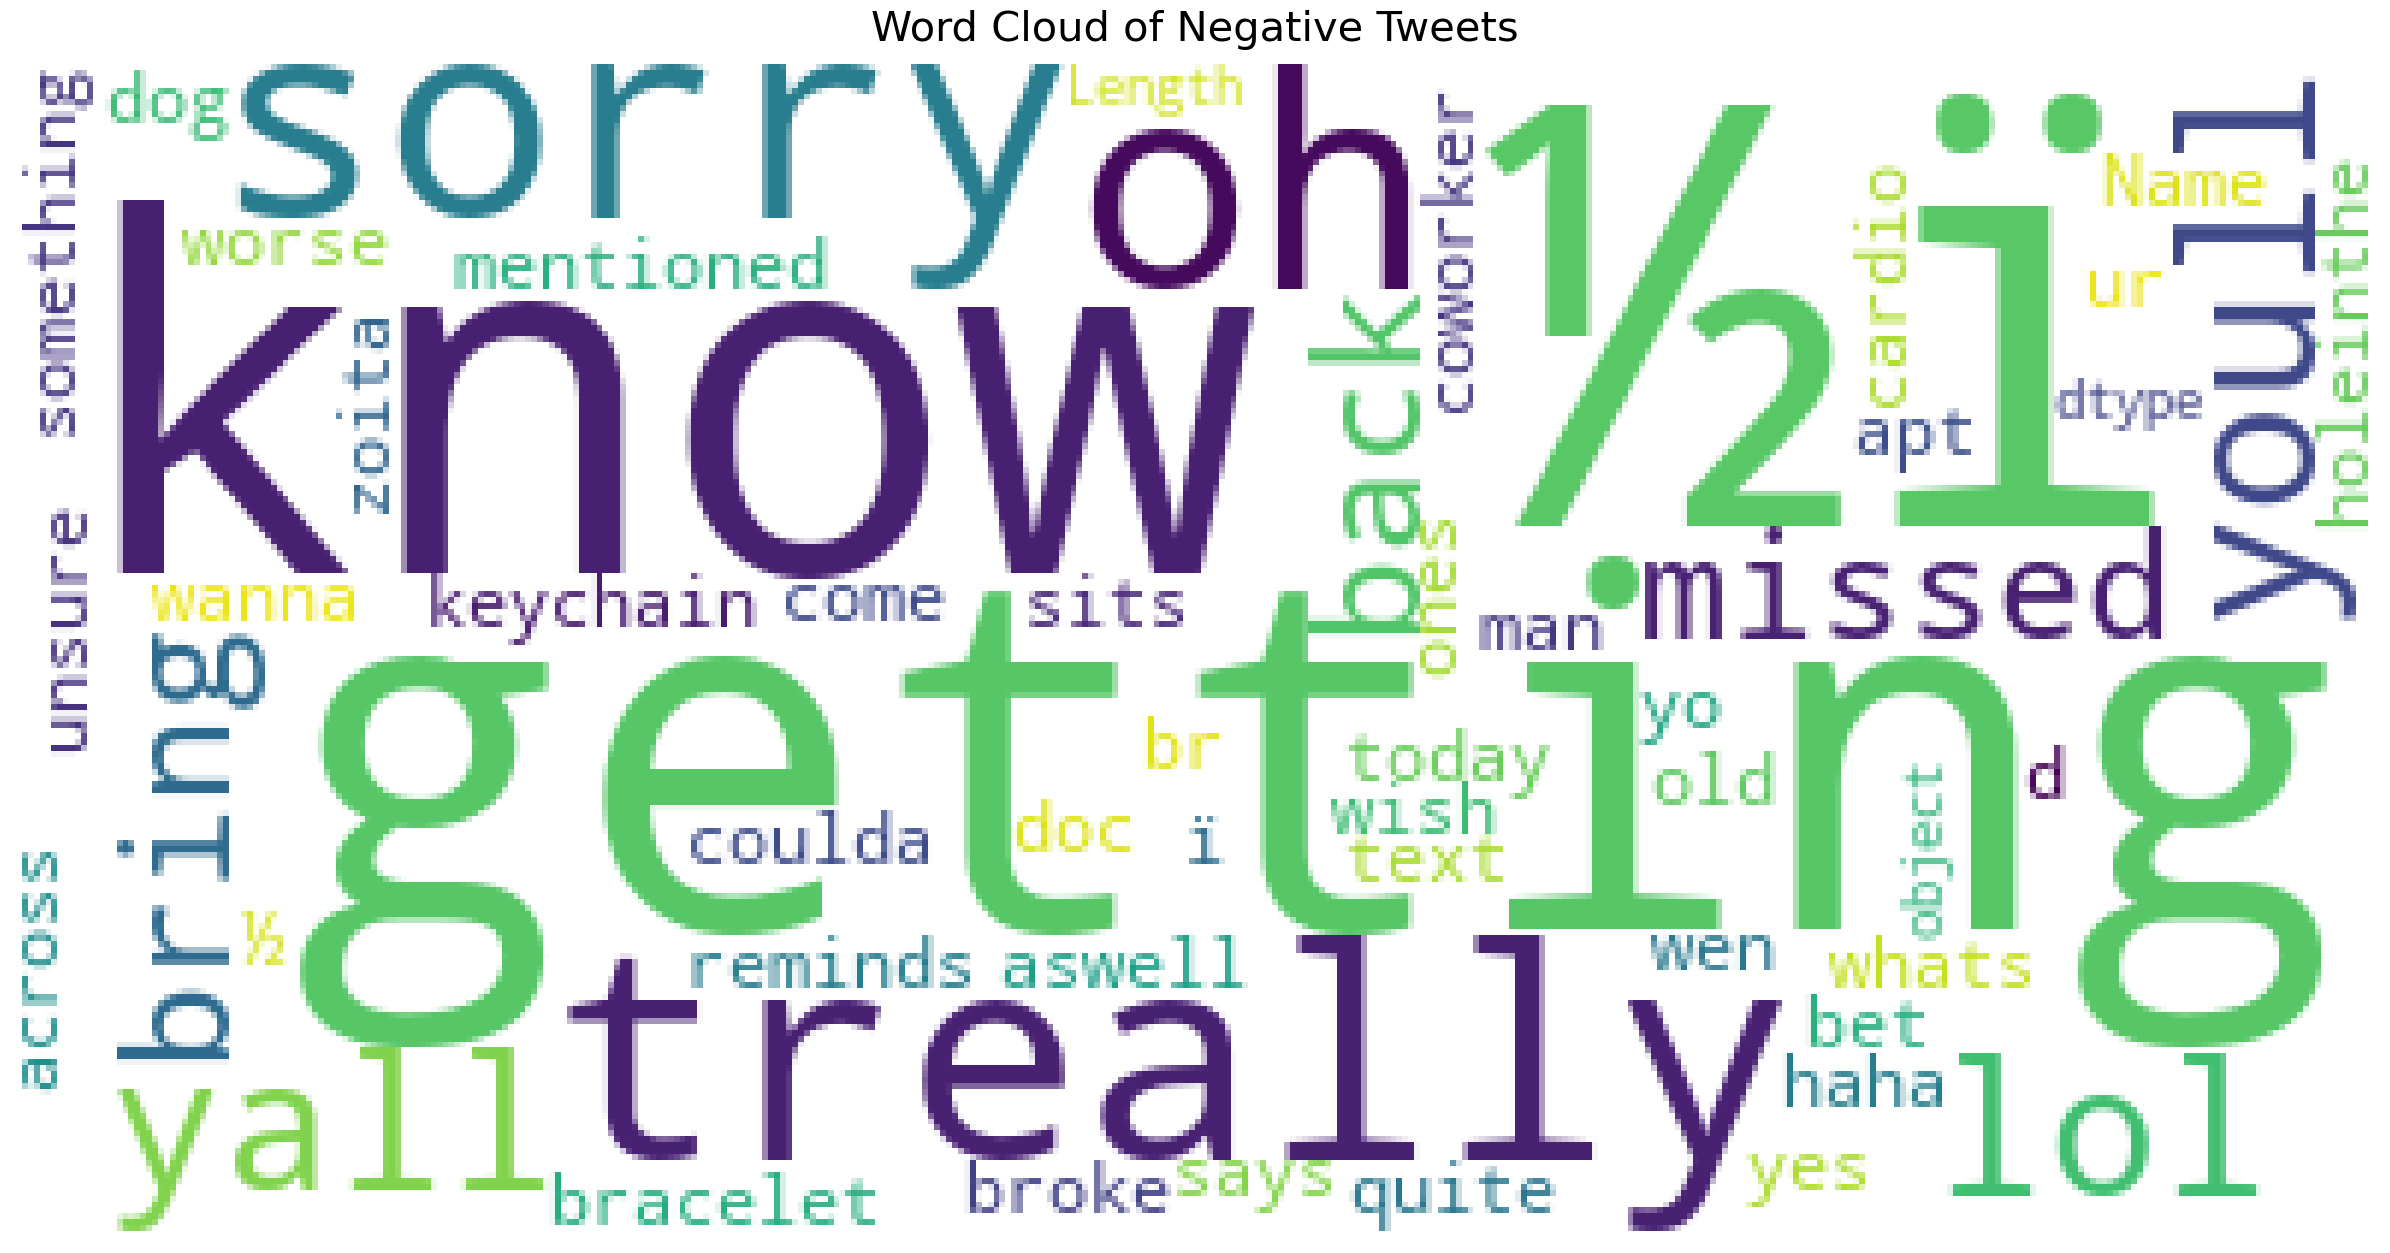

In [121]:
plot_wordcloud(Negative_sent.text,title="Word Cloud of Negative Tweets",color='white',title_size=30)

# Modelisation

In [2]:
import nbconvert

In [3]:
import pandoc